# ResEmoteNetCNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
    
class ResEmoteNet(nn.Module):
    def __init__(self):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(128)
        
        self.res_block1 = ResidualBlock(128, 256, stride=2)
        self.res_block2 = ResidualBlock(256, 512, stride=2)
        self.res_block3 = ResidualBlock(512, 1024, stride=2)
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 7)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# Training with ResEmoteNetCNN Model

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/test',  
    transform=test_transform
)

BATCH_SIZE = 16

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Initialize model, criterion, and optimizer
model = ResEmoteNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Training parameters
num_epochs = 80
patience = 15
best_val_acc = 0
patience_counter = 0
epoch_counter = 0

# History tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/train_total:.4f}',
            'acc': f'{100.*train_correct/train_total:.2f}%'
        })
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'ResEmoteNetCNN_model.pth')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs.')
        
    if patience_counter >= patience:
        print('Early stopping triggered.')
        break
    
    epoch_counter += 1

# Save final results
num_epochs_completed = len(history['train_loss'])  # Menggunakan panjang aktual dari history
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_completed + 1),
    'Train Loss': history['train_loss'],
    'Val Loss': history['val_loss'],
    'Train Acc': history['train_acc'],
    'Val Acc': history['val_acc']
})
results_df.to_csv('training_history.csv', index=False)

Using cuda device
Training set size: 28709
Validation set size: 7178


Validation: 100%|██████████| 449/449 [00:34<00:00, 12.99it/s]



Epoch 1:
Train Loss: 1.7884, Train Acc: 0.2689
Val Loss: 1.6939, Val Acc: 0.3295


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.82it/s]



Epoch 2:
Train Loss: 1.6514, Train Acc: 0.3473
Val Loss: 1.5615, Val Acc: 0.3824


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.75it/s]



Epoch 3:
Train Loss: 1.5403, Train Acc: 0.3931
Val Loss: 1.4164, Val Acc: 0.4423


Validation: 100%|██████████| 449/449 [00:12<00:00, 36.06it/s]



Epoch 4:
Train Loss: 1.4709, Train Acc: 0.4228
Val Loss: 1.3895, Val Acc: 0.4550


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.09it/s]



Epoch 5:
Train Loss: 1.4242, Train Acc: 0.4478
Val Loss: 1.3546, Val Acc: 0.4576


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.17it/s]



Epoch 6:
Train Loss: 1.3800, Train Acc: 0.4649
Val Loss: 1.3070, Val Acc: 0.4894


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.48it/s]



Epoch 7:
Train Loss: 1.3376, Train Acc: 0.4890
Val Loss: 1.3097, Val Acc: 0.5093


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.53it/s]



Epoch 8:
Train Loss: 1.3028, Train Acc: 0.5045
Val Loss: 1.2440, Val Acc: 0.5166


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.40it/s]



Epoch 9:
Train Loss: 1.2672, Train Acc: 0.5184
Val Loss: 1.2250, Val Acc: 0.5295


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.46it/s]



Epoch 10:
Train Loss: 1.2542, Train Acc: 0.5286
Val Loss: 1.2054, Val Acc: 0.5426


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.04it/s]



Epoch 11:
Train Loss: 1.2163, Train Acc: 0.5463
Val Loss: 1.1816, Val Acc: 0.5556


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.40it/s]



Epoch 12:
Train Loss: 1.1943, Train Acc: 0.5581
Val Loss: 1.1845, Val Acc: 0.5460
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.42it/s]



Epoch 13:
Train Loss: 1.1709, Train Acc: 0.5669
Val Loss: 1.1633, Val Acc: 0.5573


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.31it/s]



Epoch 14:
Train Loss: 1.1276, Train Acc: 0.5893
Val Loss: 1.1813, Val Acc: 0.5587


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.30it/s]



Epoch 15:
Train Loss: 1.1103, Train Acc: 0.5975
Val Loss: 1.1625, Val Acc: 0.5747


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.75it/s]



Epoch 16:
Train Loss: 1.0836, Train Acc: 0.6054
Val Loss: 1.1729, Val Acc: 0.5717
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.38it/s]



Epoch 17:
Train Loss: 1.0601, Train Acc: 0.6212
Val Loss: 1.1463, Val Acc: 0.5822


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.09it/s]



Epoch 18:
Train Loss: 1.0314, Train Acc: 0.6290
Val Loss: 1.1366, Val Acc: 0.5854


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.14it/s]



Epoch 19:
Train Loss: 1.0034, Train Acc: 0.6422
Val Loss: 1.1507, Val Acc: 0.5789
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.17it/s]



Epoch 20:
Train Loss: 0.9764, Train Acc: 0.6499
Val Loss: 1.1425, Val Acc: 0.5907


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.72it/s]



Epoch 21:
Train Loss: 0.9403, Train Acc: 0.6673
Val Loss: 1.1697, Val Acc: 0.5847
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.10it/s]



Epoch 22:
Train Loss: 0.9226, Train Acc: 0.6750
Val Loss: 1.1518, Val Acc: 0.5871
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.38it/s]



Epoch 23:
Train Loss: 0.8928, Train Acc: 0.6856
Val Loss: 1.1872, Val Acc: 0.5864
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.14it/s]



Epoch 24:
Train Loss: 0.8754, Train Acc: 0.6934
Val Loss: 1.1545, Val Acc: 0.5968


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.64it/s]



Epoch 25:
Train Loss: 0.8345, Train Acc: 0.7102
Val Loss: 1.2013, Val Acc: 0.5936
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.75it/s]



Epoch 26:
Train Loss: 0.8179, Train Acc: 0.7138
Val Loss: 1.1509, Val Acc: 0.5986


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.06it/s]



Epoch 27:
Train Loss: 0.7908, Train Acc: 0.7259
Val Loss: 1.1839, Val Acc: 0.5991


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.79it/s]



Epoch 28:
Train Loss: 0.7718, Train Acc: 0.7322
Val Loss: 1.2412, Val Acc: 0.5918
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.74it/s]



Epoch 29:
Train Loss: 0.7434, Train Acc: 0.7457
Val Loss: 1.2334, Val Acc: 0.5995


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.42it/s]



Epoch 30:
Train Loss: 0.7135, Train Acc: 0.7545
Val Loss: 1.2860, Val Acc: 0.6155


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.20it/s]



Epoch 31:
Train Loss: 0.6860, Train Acc: 0.7653
Val Loss: 1.2245, Val Acc: 0.6035
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.46it/s]



Epoch 32:
Train Loss: 0.6716, Train Acc: 0.7713
Val Loss: 1.3269, Val Acc: 0.6016
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.82it/s]



Epoch 33:
Train Loss: 0.6379, Train Acc: 0.7852
Val Loss: 1.3858, Val Acc: 0.6030
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.75it/s]



Epoch 34:
Train Loss: 0.6308, Train Acc: 0.7878
Val Loss: 1.2887, Val Acc: 0.5991
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.64it/s]



Epoch 35:
Train Loss: 0.5993, Train Acc: 0.7990
Val Loss: 1.3203, Val Acc: 0.6032
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.99it/s]



Epoch 36:
Train Loss: 0.5775, Train Acc: 0.8111
Val Loss: 1.4037, Val Acc: 0.5995
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.89it/s]



Epoch 37:
Train Loss: 0.5663, Train Acc: 0.8126
Val Loss: 1.3947, Val Acc: 0.6002
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.46it/s]



Epoch 38:
Train Loss: 0.5433, Train Acc: 0.8211
Val Loss: 1.4035, Val Acc: 0.6066
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.24it/s]



Epoch 39:
Train Loss: 0.5223, Train Acc: 0.8297
Val Loss: 1.4509, Val Acc: 0.6052
No improvement for 9 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.74it/s]



Epoch 40:
Train Loss: 0.5089, Train Acc: 0.8344
Val Loss: 1.5117, Val Acc: 0.6004
No improvement for 10 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.15it/s]



Epoch 41:
Train Loss: 0.4952, Train Acc: 0.8382
Val Loss: 1.6091, Val Acc: 0.5903
No improvement for 11 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.51it/s]



Epoch 42:
Train Loss: 0.4737, Train Acc: 0.8451
Val Loss: 1.4973, Val Acc: 0.6004
No improvement for 12 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.44it/s]



Epoch 43:
Train Loss: 0.4607, Train Acc: 0.8505
Val Loss: 1.5880, Val Acc: 0.5972
No improvement for 13 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.83it/s]



Epoch 44:
Train Loss: 0.4466, Train Acc: 0.8587
Val Loss: 1.5794, Val Acc: 0.6121
No improvement for 14 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.49it/s]


Epoch 45:
Train Loss: 0.4434, Train Acc: 0.8613
Val Loss: 1.6225, Val Acc: 0.5931
No improvement for 15 epochs.
Early stopping triggered.


In [3]:
import warnings
warnings.filterwarnings('ignore')

def convert_pth_to_pt(model_path, output_path='model.pt'):
    """
    Convert .pth checkpoint to .pt format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .pt model file
    Returns:
        str: Path to saved .pt model
    """
    try:
        # Initialize model
        model = ResEmoteNet()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Set model to eval mode
        model.eval()
        
        # Save model in .pt format
        torch.save(model, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_pth_to_ptl(model_path, output_path='model.ptl'):
    """
    Convert .pth checkpoint to .ptl (PyTorch Lightning) format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .ptl model file
    Returns:
        str: Path to saved .ptl model
    """
    try:
        # Initialize model
        model = ResEmoteNet()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Create new state dict with Lightning compatible format
        new_state_dict = {
            'state_dict': checkpoint['model_state_dict'],
            'epoch': checkpoint.get('epoch', 0),
            'global_step': 0,
            'pytorch-lightning_version': '2.0.0',
            'callbacks': {},
            'optimizer_states': [checkpoint.get('optimizer_state_dict', {})],
            'lr_schedulers': [],
            'hparams_name': 'ResEmoteNet',
            'hyper_parameters': {
                'learning_rate': 0.001,
                'batch_size': 16,
                'num_classes': 7
            }
        }
        
        # Save in Lightning format
        torch.save(new_state_dict, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_all_formats(model_path, base_output_name='model'):
    """
    Convert .pth model to both .pt and .ptl formats
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        base_output_name (str): Base name for output files
    Returns:
        tuple: Paths to saved .pt and .ptl models
    """
    pt_path = f"{base_output_name}.pt"
    ptl_path = f"{base_output_name}.ptl"
    
    pt_result = convert_pth_to_pt(model_path, pt_path)
    ptl_result = convert_pth_to_ptl(model_path, ptl_path)
    
    return pt_result, ptl_result

# Example usage:
"""
# For single format conversion:
pt_path = convert_pth_to_pt('ResEmoteNetCNN_model.pth')
# or
ptl_path = convert_pth_to_ptl('ResEmoteNetCNN_model.pth')

# For converting to both formats:
pt_path, ptl_path = convert_all_formats('ResEmoteNetCNN_model.pth', 'ResEmoteNet')
"""

def plot_training_curves(history):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training Analysis', fontsize=16, y=1.05)

    # Loss curves
    axes[0,0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0,0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0,0].set_title('Loss Curves')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Accuracy curves
    axes[0,1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0,1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0,1].set_title('Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Learning curves (Training vs Validation Gap)
    train_val_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1,0].plot(train_val_gap, label='Train-Val Accuracy Gap', color='purple')
    axes[1,0].set_title('Overfitting Analysis')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy Gap')
    axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Learning Rate if available
    if 'lr' in history:
        axes[1,1].plot(history['lr'], label='Learning Rate', color='green')
        axes[1,1].set_title('Learning Rate Schedule')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Learning Rate')
        axes[1,1].set_yscale('log')
        axes[1,1].legend()
        axes[1,1].grid(True)
    else:
        fig.delaxes(axes[1,1])  # Better way to remove subplot

    plt.tight_layout()
    plt.savefig('training_curves.png', bbox_inches='tight', dpi=300)
    plt.show()

def evaluate_model(model, val_loader, device, class_names):

    model.eval()
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")

def plot_sample_predictions(model, val_loader, device, class_names, num_samples=5):

    model.eval()
    
    try:
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
        
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            
            for i in range(min(num_samples, len(inputs))):
                # Plot image
                img = inputs[i].cpu().permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = img.clip(0, 1)
                
                axes[0, i].imshow(img)
                axes[0, i].axis('off')
                true_label = class_names[labels[i]]
                pred_label = class_names[outputs[i].argmax()]
                axes[0, i].set_title(f'True: {true_label}\nPred: {pred_label}',
                                   color='green' if true_label == pred_label else 'red')
                
                # Plot probability distribution
                probs = probabilities[i].cpu().numpy()
                axes[1, i].bar(range(len(class_names)), probs)
                axes[1, i].set_xticks(range(len(class_names)))
                axes[1, i].set_xticklabels(class_names, rotation=45)
                axes[1, i].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig('sample_predictions.png', bbox_inches='tight', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")

def print_parameter_details(model):
    """
    Print model parameter details and total trainable parameters.
    
    Args:
        model (torch.nn.Module): The model to analyze
    """
    try:
        total_params = 0
        print("\nModel Parameter Details:")
        print("-" * 50)
        for name, parameter in model.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                total_params += params
                print(f"{name:<30} {params:>10,d}")
        print("-" * 50)
        print(f"Total trainable parameters: {total_params:,}")
        
    except Exception as e:
        print(f"Error analyzing parameters: {str(e)}")


Model Parameter Details:
--------------------------------------------------
conv1.weight                          864
conv1.bias                             32
bn1.weight                             32
bn1.bias                               32
conv2.weight                       18,432
conv2.bias                             64
bn2.weight                             64
bn2.bias                               64
conv3.weight                       73,728
conv3.bias                            128
bn3.weight                            128
bn3.bias                              128
se.fc.0.weight                      1,024
se.fc.2.weight                      1,024
res_block1.conv1.weight           294,912
res_block1.conv1.bias                 256
res_block1.bn1.weight                 256
res_block1.bn1.bias                   256
res_block1.conv2.weight           589,824
res_block1.conv2.bias                 256
res_block1.bn2.weight                 256
res_block1.bn2.bias                   256

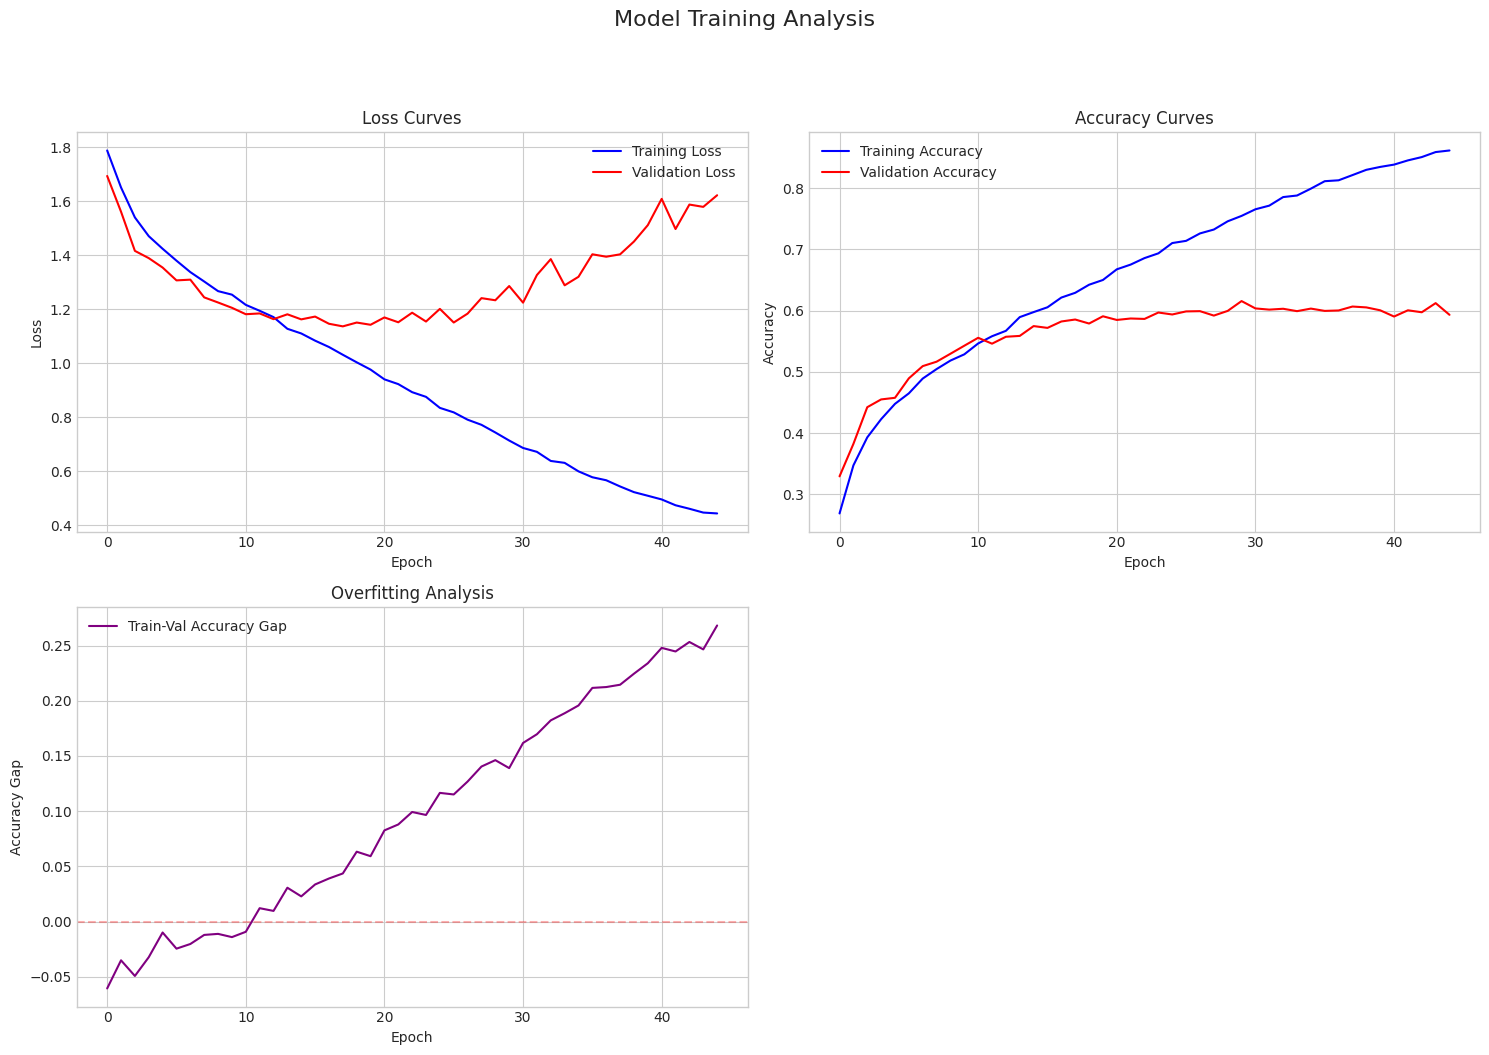

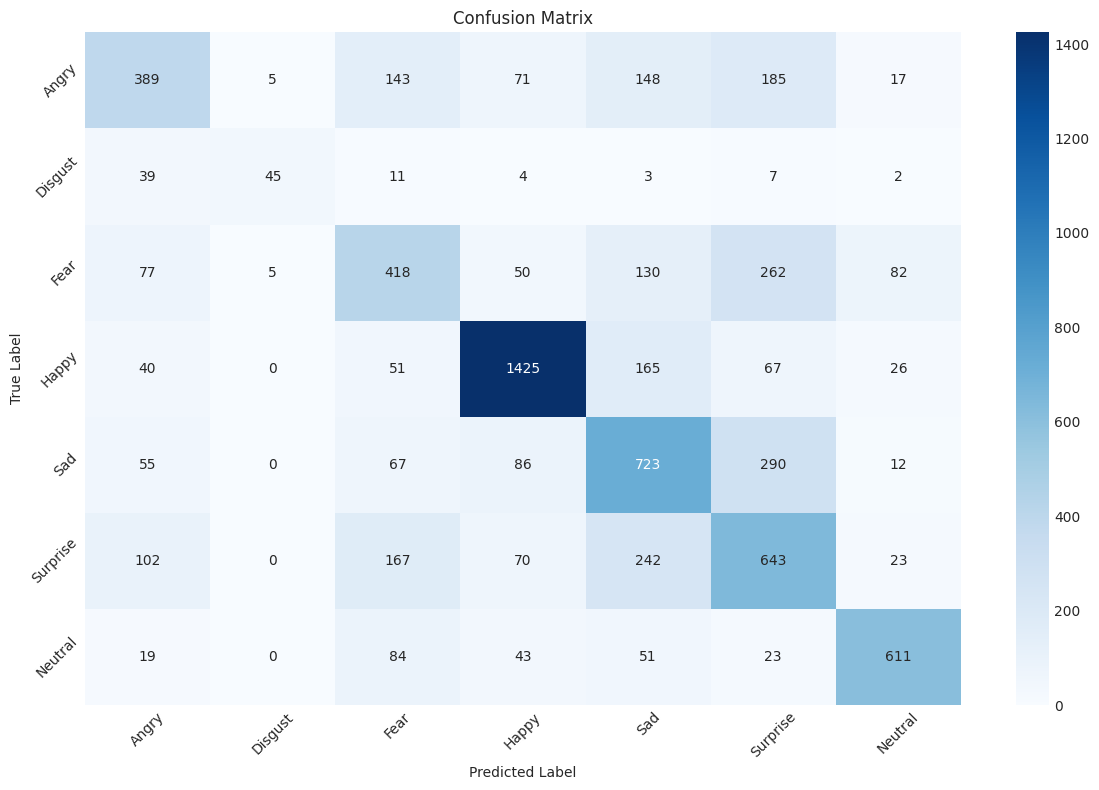


Classification Report:
              precision    recall  f1-score   support

       Angry       0.54      0.41      0.46       958
     Disgust       0.82      0.41      0.54       111
        Fear       0.44      0.41      0.43      1024
       Happy       0.81      0.80      0.81      1774
         Sad       0.49      0.59      0.54      1233
    Surprise       0.44      0.52      0.47      1247
     Neutral       0.79      0.74      0.76       831

    accuracy                           0.59      7178
   macro avg       0.62      0.55      0.57      7178
weighted avg       0.60      0.59      0.59      7178



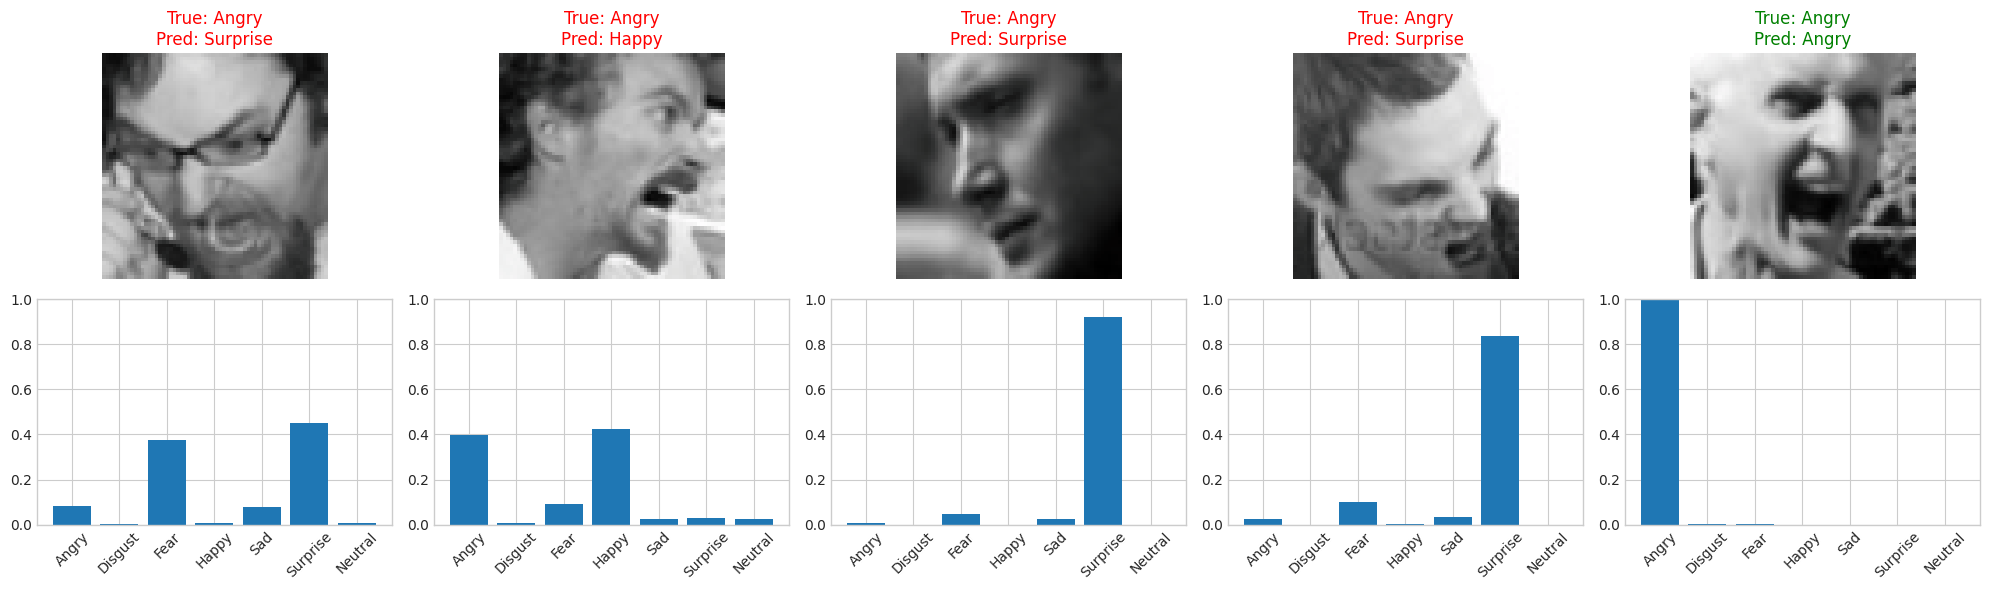

In [4]:
print_parameter_details(model)

pt_path, ptl_path = convert_all_formats('ResEmoteNetCNN_model.pth', 'ResEmoteNet')

plot_training_curves(history)

# Definisikan nama kelas sesuai dengan dataset FER2013
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Evaluasi model dan tampilkan confusion matrix
evaluate_model(model, val_loader, device, class_names)

# Tampilkan contoh prediksi
plot_sample_predictions(model, val_loader, device, class_names)